In [1]:
!pip install auto-sklearn &> /dev/null
!pip uninstall -y scipy &> /dev/null
!pip install scipy==1.7.3 &> /dev/null
!pip install xlrd==2.0.0 &> /dev/null
!pip install scikit-multiflow &> /dev/null
print('Installs finished')

Installs finished


In [1]:
import pandas as pd
import numpy as np
import re
import spacy
from tqdm import tqdm
from datetime import datetime
from itertools import compress
import matplotlib.pyplot as plt
import random
from random import sample
from sklearn.base import TransformerMixin
import pickle
import autosklearn.classification
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_recall_fscore_support
import glob
from time import time
from sklearn.model_selection import train_test_split

rng = np.random.default_rng(4711)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
commentsDF = pd.DataFrame(columns={'ID'})
for file in glob.glob("/content/drive/MyDrive/MA/Daten/*"):
     tempDF = pd.read_excel(file)
     commentsDF = pd.concat([commentsDF, tempDF], join='outer')

commentsDF = commentsDF.drop(columns=['ID', 'Active', 'CID', 'Sperrhinweis', 'Loginname'],axis=1)

commentsDF['Date'] =  pd.to_datetime(commentsDF['Date'], format='%Y-%m-%d %H:%M:%S')
commentsDF['Time'] = pd.to_datetime(commentsDF['Date']).dt.time
commentsDF['Date'] = pd.to_datetime(commentsDF['Date']).dt.date
commentsDF['Date'] = pd.to_datetime(commentsDF['Date'], format='%Y-%m-%d')


commentsDF['Text'] = commentsDF['Text'].astype(str)
commentsDF['Title'] = commentsDF['Title'].astype(str)

commentsDF = commentsDF.drop_duplicates(subset=['Text']) 
commentsDF = commentsDF.sort_values(by=['Date']).reset_index(drop=True)

In [4]:
# creates Sampled down version of dataset

dateRange = pd.period_range(start='2018-11-01', end='2020-06-01', freq='M')
timeSampledDF = pd.DataFrame(columns={'ID'})


for i in range(len(dateRange)):
  month = dateRange[i].month
  year = dateRange[i].year
  monthData = commentsDF[(commentsDF.Date.dt.month == dateRange[i].month) & (commentsDF.Date.dt.year == dateRange[i].year)]
  countMinor = len(monthData[monthData.Abgelehnt == 1])
  if countMinor < 600:
    countMinor = 600
  minorityDF = monthData[monthData.Abgelehnt == 1]
  majorityDF = monthData[monthData.Abgelehnt == 0].sample(axis='index', 
                                                          n=countMinor, 
                                                          random_state=4711,)
  timeSampledDF = pd.concat([timeSampledDF, majorityDF], join='outer')
  timeSampledDF = pd.concat([timeSampledDF, minorityDF], join='outer')

y_vals = commentsDF['Abgelehnt'].values
y_vals = y_vals.astype(int)


commentsDF['index1'] = commentsDF.index
timeSampledDF['index1'] = timeSampledDF.index
timeSampledDF.sort_values(by='Date',inplace=True)


commentsDF['Mask'] = commentsDF.index1.apply(lambda x: 1 if x in timeSampledDF.index1 else 0)
mask = np.array(commentsDF['Mask']).astype('bool')


In [ ]:
# !pip install https://github.com/explosion/spacy-models/releases/download/de_core_news_lg-3.3.0/de_core_news_lg-3.3.0.tar.gz &> /dev/null
# class TextPreprocessingTransformer(TransformerMixin):
#     def __init__(self):
#         pass

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         documents = []
#         nlp = spacy.load("de_core_news_lg")
#         for sen in tqdm(range(0, len(X))):
#             # Remove all the special characters
#             document = re.sub(r'\W', ' ', str(X[sen]))

#             # Remove numbers
#             document = re.sub(r'[0-9]', ' ', document)

#             # remove all single characters
#             document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

#             # Remove single characters from the start
#             document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

#             # Substituting multiple spaces with single space
#             document = re.sub(r'\s+', ' ', document, flags=re.I)

#             # Removing prefixed 'b'
#             document = re.sub(r'^b\s+', '', document)

#             # Converting to Lowercase
#             document = document.lower()

#             # Lemmatization
#             document = nlp(document)
 
#             document = [word.lemma_ for word in document]
#             document = ' '.join(document)
        
#             documents.append(document)

#         return documents

In [5]:
german_stop_words_import = open ("/content/drive/MyDrive/MA/stopwords-de.csv", 
                                 "r", encoding="utf-8")
german_stop_words = pd.read_csv(german_stop_words_import, 
                                names=['stopwords'])['stopwords'].to_list()

vectorizer = TfidfVectorizer(stop_words=german_stop_words, 
                             ngram_range=(1,2), max_features=3000)

# preprocessor = TextPreprocessingTransformer()
# preprocessed = preprocessor.transform(np.array(timeSampledDF["Text"]))

# with open('sample_preprocessed.pk', 'wb') as fin:
#     pickle.dump(preprocessed, fin)

tfidf_pickle = open ("/content/drive/MyDrive/MA/preprocessed_balanced.pk", "rb")
preprocessed = pickle.load(tfidf_pickle)

tfidf = vectorizer.fit_transform(preprocessed)

In [ ]:
# with open('preprocessed_balanced.pk', 'wb') as fin:
#     pickle.dump(preprocessed, fin)

In [6]:
def testModel(model, x_test, y_test):
  

  y_pred = model.predict(x_test)
  scores = precision_recall_fscore_support(y_test, y_pred, average="macro")
  accuracy = accuracy_score(y_test, y_pred)
  roc_score = roc_auc_score(y_test,y_pred)

  resultDF = pd.DataFrame({'ROC-AUC': [roc_score], 'Precision': [scores[0]],
                           'Recall': [scores[1]], 'F1-Score': [scores[2]],
                          'Accuracy' : accuracy})

  return resultDF

In [7]:
testMask = timeSampledDF.Date >= "2019-11-01"
evalFrame = list(compress(preprocessed, testMask))
y_vals_sample = timeSampledDF['Abgelehnt'].values


rng = np.random.default_rng(4711)

msk= np.array( [False]*len(timeSampledDF))

inds=np.random.choice(len(msk), size=int(len(timeSampledDF)*0.7))
msk[inds] = True

testMsk = ~msk

preprocessFrame = timeSampledDF
preprocessFrame.Text = preprocessed

trainSet = preprocessFrame[msk]
x_train = trainSet.Text
y_train = trainSet.Abgelehnt

testDF = preprocessFrame
testDF['Mask'] = testMsk
testDF.loc[testDF['Date'] < '2019-11-01', 'Mask'] = False
testMsk = testDF['Mask']

testSet = preprocessFrame[testMsk]

x_test = testSet.Text
y_test = testSet.Abgelehnt

vectorizer = vectorizer.fit(x_train)

In [13]:
testSet

,ID,Date,Text,Title,Abgelehnt,Sperrhinweis_Text,Time,index1,Mask
158839,NaN,2019-11-01,und dann bitte gleich weitermachen denn über d...,Kommentar zu: Über „Du Jude“ muss geredet werden,1.0,NaN,15:58:40,158839,True
158854,NaN,2019-11-01,unfassbar was mit der Kid heute los sein warte...,Kommentar zu: 13-Jähriger am Bahnhof in Dinsla...,1.0,NaN,10:08:24,158854,True
158794,NaN,2019-11-01,dann sein ich über aller Berg und sicher nicht...,Kommentar zu: Kretschmann hält Habeck für geei...,1.0,NaN,18:32:37,158794,True
158817,NaN,2019-11-01,Hobre ich haben dieser Artikel nicht ganz du...,Kommentar zu: „Die Tonspur ist für die meisten...,1.0,NaN,20:09:13,158817,True
158816,NaN,2019-11-01,Orinoko mit dieser Kalauer können sie glatt ...,Kommentar zu: Heidi Klum verwandelt sich öffen...,1.0,NaN,20:12:19,158816,True
...,...,...,...,...,...,...,...,...,...
254221,NaN,2020-06-29,da werden mal wieder sinnlos Zeichen setzen st...,Kommentar zu: Nicht-weiße Simpsons-Figuren s...,0.0,NaN,09:59:03,254221,True
254144,NaN,2020-06-29,sehr gut der nennen man verkehrswend weniger a...,Kommentar zu: SPD will Tempo 30 in ganz Düssel...,0.0,NaN,07:56:02,254144,True
254121,NaN,2020-06-29,Leute ohne erneut Schließung der Gaststätte Bi...,Kommentar zu: Wie Düsseldorf die Corona-Verstö...,0.0,NaN,09:05:42,254121,True
254228,NaN,2020-06-29,irgendwann werden es dieser unsäglich politica...,Kommentar zu: Mississippi streicht Konföderier...,0.0,NaN,09:48:28,254228,True


### AutoML Model trained on randomly selected data


In [ ]:
x_train = vectorizer.transform(x_train).toarray()
automl_independent = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=21600,
    n_jobs=-1,
    metric = autosklearn.metrics.f1
)

automl_independent.fit(x_train, y_train)
# automl_independent_load = open ("/content/drive/MyDrive/MA/autoML_random.pk", "rb")
# automl_independent = pickle.load(automl_independent_load)

AutoSklearnClassifier(metric=f1, n_jobs=-1, per_run_time_limit=4320,
                      time_left_for_this_task=21600)

In [ ]:
with open('autoML_random.pk', 'wb') as fin:
  pickle.dump(automl_independent, fin)

In [ ]:
# show all models for training on random train sample
# show_models_str_ind = automl_independent.show_models()
sprint_statistics_str_ind = automl_independent.sprint_statistics()
# print(show_models_str_ind, sprint_statistics_str_ind)

# print("Sprint Statistics: ", sprint_statistics_str_ind)

In [ ]:
# model tests per month
import calendar
testMonths = pd.to_datetime(['11-19','12-19','01-20', '02-20','03-20','04-20','05-20','06-20'],
                            format='%m-%y')

output = pd.DataFrame()
for i in range(len(testMonths)):
  monthMask = (testSet.Date.dt.month == testMonths[i].month) & (testSet.Date.dt.year == testMonths[i].year)

  y_months = y_test[monthMask]
  x_months = vectorizer.transform(np.array(x_test)[monthMask]).toarray()
  
  results = testModel(automl_independent, x_months, y_months)
  output = output.append(results)
  print('Results for {}: \n'.format(testMonths[i].strftime("%b %y")), results)
output.index = testMonths
output.to_excel('Results.xlsx')

Results for Nov 19: 
    ROC-AUC  Precision   Recall  F1-Score  Accuracy
0  0.67274   0.691457  0.67274   0.66346  0.671182
Results for Dec 19: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.631127   0.645249  0.631127  0.618636  0.626263
Results for Jan 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.637526    0.66075  0.637526  0.625747  0.640387
Results for Feb 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.646784   0.683533  0.646784  0.630727  0.650746
Results for Mar 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.654836    0.69106  0.654836  0.641042  0.660061
Results for Apr 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.655296   0.658503  0.655296  0.608829  0.608949
Results for May 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.637864   0.647124  0.637864  0.601881   0.60334
Results for Jun 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.664821   0.643632  0.664821 

In [ ]:
x_test_transformed = vectorizer.transform(np.array(x_test)).toarray()

print(testModel(automl_independent, x_test_transformed, y_test))

    ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.650074   0.670265  0.650074  0.627948  0.634813


In [ ]:
x_test_transformed.shape

(2900, 3000)

--------------------------------------------------------------------------------
# AutoML Model trained on time-framed data


### Short pre Test with only 3 month batch for Training

In [ ]:
train_batch = np.array((timeSampledDF.Date < "2019-11-01") & (timeSampledDF.Date >= "2019-08-01"))
test = timeSampledDF['Date'] >= "2019-11-01"

x_timed = list(compress(preprocessed, train_batch))

y_train_timed = y_vals_sample[train_batch]
x_train_timed = vectorizer.fit_transform(x_timed).toarray()

In [ ]:
automl_timed_3m = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=360,
    n_jobs=-1,
    metric = autosklearn.metrics.f1
)

automl_timed_3m.fit(x_train_timed, y_train_timed)
# automl_timed_load = open ("/content/drive/MyDrive/MA/autoML_timed_3month.pk", "rb")
# automl_timed = pickle.load(automl_timed_load)

AutoSklearnClassifier(metric=f1, n_jobs=-1, per_run_time_limit=72,
                      time_left_for_this_task=360)

In [ ]:
# model tests per month
import calendar
testMonths = pd.to_datetime(['11-19','12-19','01-20', '02-20','03-20','04-20','05-20','06-20'],
                            format='%m-%y')

output = pd.DataFrame()
for i in range(len(testMonths)):
  monthMask = (testSet.Date.dt.month == testMonths[i].month) & (testSet.Date.dt.year == testMonths[i].year)

  y_months = y_test[monthMask]
  x_months = vectorizer.transform(np.array(x_test)[monthMask]).toarray()
  
  results = testModel(automl_timed_3m, x_months, y_months)
  output = output.append(results)
  print('Results for {}: \n'.format(testMonths[i].strftime("%b %y")), results)
output.index = testMonths
# output.to_excel('Results.xlsx')

Results for Nov 19: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.634191   0.634439  0.634191  0.634023  0.634191
Results for Dec 19: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.592928   0.593395  0.592928  0.592418  0.592928
Results for Jan 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.582173    0.58279  0.582173  0.581392  0.582173
Results for Feb 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.576531   0.576632  0.576531   0.57639  0.576531
Results for Mar 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.574468   0.574468  0.574468  0.574468  0.574468
Results for Apr 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.590061   0.586792  0.590061  0.585847  0.593781
Results for May 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.587149   0.582763  0.587149  0.577963  0.583673
Results for Jun 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.624424   0.597339  0.624

In [ ]:
x_test_transformed = vectorizer.transform(x_test).toarray()

print(testModel(automl_timed_3m, x_test_transformed, y_test))

    ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.544138   0.543835  0.544138  0.543025  0.543788


### Real AutoML timed

In [8]:
train_batch = np.array(timeSampledDF.Date < "2019-11-01")
test = timeSampledDF['Date'] >= "2019-11-01"

x_timed = list(compress(preprocessed, train_batch))

y_train_timed = y_vals_sample[train_batch]
x_train_timed = vectorizer.fit_transform(x_timed).toarray()

In [ ]:
len(x_train_timed)

23332

In [9]:
vectorizer = vectorizer.fit(x_timed)

In [10]:
# automl_timed = autosklearn.classification.AutoSklearnClassifier(
#     time_left_for_this_task=21600,
#     n_jobs=-1,
#     metric = autosklearn.metrics.f1
# )

# automl_timed.fit(x_train_timed, y_train_timed)
automl_timed_load = open ("/content/drive/MyDrive/MA/autoML_timed_balanced.pk", "rb")
automl_timed = pickle.load(automl_timed_load)

In [ ]:
# with open('autoML_timed_balanced.pk', 'wb') as fin:
#   pickle.dump(automl_timed, fin)

In [11]:
# show all models for training on first half of data
show_models_str = automl_timed.show_models()
sprint_statistics_str = automl_timed.sprint_statistics()

print(sprint_statistics_str, show_models_str)

auto-sklearn results:
  Dataset name: 4e0dc26c-1f3f-11ed-80fd-0242ac1c0002
  Metric: f1
  Best validation score: 0.687114
  Number of target algorithm runs: 111
  Number of successful target algorithm runs: 95
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 5
  Number of target algorithms that exceeded the memory limit: 10
 {51: {'model_id': 51, 'rank': 1, 'cost': 0.3128855380397533, 'ensemble_weight': 0.5, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f488b67f990>, 'balancing': Balancing(random_state=1), 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f487f54a690>, 'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f487c011850>, 'sklearn_classifier': QuadraticDiscriminantAnalysis(reg_param=0.03631232237607662)}, 87: {'model_id': 87, 'rank': 2, 'cost': 0.3310

In [12]:
# model tests per month
import calendar
testMonths = pd.to_datetime(['11-19','12-19','01-20', '02-20','03-20','04-20','05-20','06-20'],
                            format='%m-%y')

output = pd.DataFrame()
for i in range(len(testMonths)):
  monthMask = (testSet.Date.dt.month == testMonths[i].month) & (testSet.Date.dt.year == testMonths[i].year)

  y_months = y_test[monthMask]
  x_months = vectorizer.transform(np.array(x_test)[monthMask]).toarray()
  
  results = testModel(automl_timed, x_months, y_months)
  output = output.append(results)
  print('Results for {}: \n'.format(testMonths[i].strftime("%b %y")), results)
output.index = testMonths
output.to_excel('Results.xlsx')

Results for Nov 19: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.617592   0.677543  0.617592  0.584362  0.620818
Results for Dec 19: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.597076   0.672865  0.597076  0.555427  0.610475
Results for Jan 20: 
    ROC-AUC  Precision   Recall  F1-Score  Accuracy
0  0.56839   0.612643  0.56839  0.513936  0.556005
Results for Feb 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.581264   0.657792  0.581264  0.524714  0.583333
Results for Mar 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.581743   0.663914  0.581743  0.513046  0.567485
Results for Apr 20: 
    ROC-AUC  Precision  Recall  F1-Score  Accuracy
0   0.5936   0.626332  0.5936  0.525987  0.540206
Results for May 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.561589   0.592613  0.561589  0.462014  0.479508
Results for Jun 20: 
     ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.603456   0.610317  0.603456  0.450

In [ ]:
x_test_transformed = vectorizer.transform(x_test).toarray()

print(testModel(automl_timed, x_test_transformed, y_test))

    ROC-AUC  Precision    Recall  F1-Score  Accuracy
0  0.505303   0.537373  0.505303   0.35135  0.466865


In [ ]:
print(testSet[testSet.Date >= '2020-06-01'])

         ID       Date                                               Text  \
243645  NaN 2020-06-01  wie bereits vor der Pfingsttag äußern man reic...   
243735  NaN 2020-06-01  sehr geehrt Dame und Herr ich haben gerne der ...   
243632  NaN 2020-06-01              Glutnester in der Hosetaschen stecken   
243600  NaN 2020-06-01  ich finden es total ärgerlich dass ich sich se...   
243592  NaN 2020-06-01    Zenjähriger aus Thüringen legen Glutnester i...   
...     ...        ...                                                ...   
254227  NaN 2020-06-29  so ein Typ der funktionieren halt nur bei Bvb ...   
254111  NaN 2020-06-29  schon eigenartig wie der einer der anderer wag...   
254215  NaN 2020-06-29  der ewig grinsend Stehaufmännch der SPD der Fe...   
254044  NaN 2020-06-29  perfekt Planung Beschattung gegen sommerlich H...   
254256  NaN 2020-06-29  na dann sein ich ja beruhigen dass frl Julia z...   

                                                    Title  Abgelehnt  \
243

# Distribution of Prediction Error

In [ ]:
df = pd.DataFrame()
df['Date'] = timeSampledDF[timeSampledDF.Date >= '2019-11-01']['Date']
df['x'] = 1
df.sort_values(by='Date',inplace=True)

,Date,x
158839,2019-11-01,1
158997,2019-11-01,1
158677,2019-11-01,1
158731,2019-11-01,1
158974,2019-11-01,1
...,...,...
254220,2020-06-29,1
254248,2020-06-29,1
254022,2020-06-29,1
253984,2020-06-29,1


In [ ]:
x_test = list(compress(preprocessed, testMask))
x_test_transformed = vectorizer.transform(x_test).toarray()
y_pred = automl_timed.predict(x_test_transformed)

In [ ]:
testMask = timeSampledDF.Date >= "2019-11-01"

0.5800774375219993


In [ ]:
y_pred_independent = automl_independent.predict(x_test_transformed)

In [ ]:
predDF = pd.DataFrame()

predDF['Date'] = timeSampledDF[timeSampledDF.Date >= '2019-11-01']['Date']
predDF['Count'] = 1
predDF['Error'] = abs(y_pred - timeSampledDF[timeSampledDF.Date >= '2019-11-01']['Abgelehnt'])
predDF['Date'] = pd.to_datetime(predDF['Date']) - pd.to_timedelta(7, unit='d')
predDF = predDF.resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')
predDF['Weighted Error'] = predDF['Error']/predDF['Count']


In [ ]:
independentDF = pd.DataFrame()
independentDF['Date'] = timeSampledDF[timeSampledDF.Date >= '2019-11-01']['Date']
independentDF['Count'] = 1
independentDF['Error'] = abs(y_pred_independent - timeSampledDF[timeSampledDF.Date >= '2019-11-01']['Abgelehnt'])
independentDF['Date'] = pd.to_datetime(independentDF['Date']) - pd.to_timedelta(7, unit='d')
independentDF = independentDF.resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')
independentDF['Weighted Error'] = independentDF['Error']/independentDF['Count']


In [ ]:
ppnse_pickle = open ("/content/drive/MyDrive/MA/ppnseDF.pk", "rb")
ppnseDF = pickle.load(ppnse_pickle)
ppnseDF['Error'] = abs(ppnseDF['y_pred'] - timeSampledDF[timeSampledDF.Date >= '2019-11-01']['Abgelehnt'])
ppnseDF['Count'] = 1
ppnseDF = ppnseDF.resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')
ppnseDF['Weighted Error'] = ppnseDF['Error']/ppnseDF['Count']


In [ ]:
# predDF['Std Dev'] = predDF.apply(lambda x: )

In [ ]:
from skmultiflow.drift_detection import DDM, ADWIN, EDDM, HDDM_A
ddm=DDM()


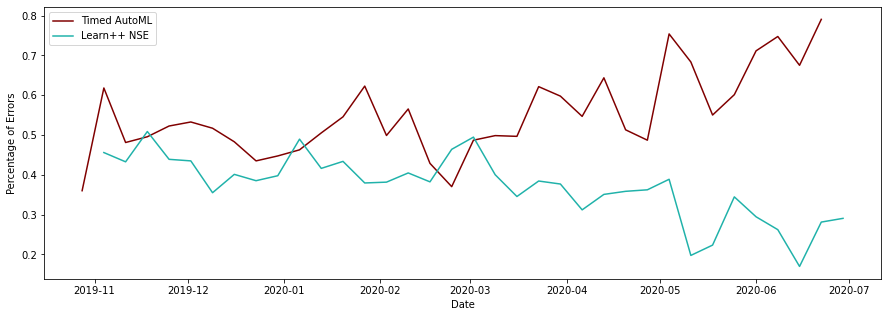

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))


ax.plot(predDF.Date, predDF['Weighted Error'], label='Timed AutoML',color='maroon')
ax.plot(ppnseDF.Date, ppnseDF['Weighted Error'], label='Learn++ NSE', color='lightseagreen')
# ax.plot(independentDF.Date, independentDF.Error, label='Random AutoML')

ax.set_xlabel('Date')
ax.set_ylabel('Percentage of Errors')

ax.legend()
# plt.savefig('Distribution of Accepted and Denied Comments - with Trendline.png')

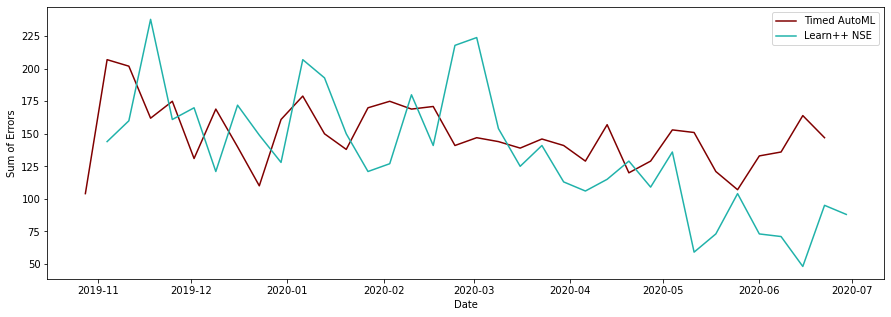

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))


ax.plot(predDF.Date, predDF.Error, label='Timed AutoML',color='maroon')
ax.plot(ppnseDF.Date, ppnseDF.Error, label='Learn++ NSE', color='lightseagreen')
# ax.plot(independentDF.Date, independentDF.Error, label='Random AutoML')

ax.set_xlabel('Date')
ax.set_ylabel('Sum of Errors')

ax.legend()
# plt.savefig('Distribution of Accepted and Denied Comments - with Trendline.png')

# Tests on a weekly Basis 

In [ ]:
weekDF = pd.DataFrame()

x_test = vectorizer.fit_transform(timeSampledDF['Text'][test]).toarray()
y_pred = automl_timed.predict(x_test)

weekDF['Date'] = timeSampledDF['Date'][test]
weekDF['Prediction'] = y_pred
weekDF['Actual'] = timeSampledDF['Abgelehnt']
weekDF

In [ ]:
weekDF